In [350]:
import pickle
import pickle
from typing import Dict, Tuple, Optional, List, Union

import numpy as np
import pandas as pd
from pyteomics import mass
from common import LYS

from precursor import Mod, Peptide, Residue, err_margin, compute_error, within_bounds

from fragments import MultiP

from measurement import read_mgf

import fragments as fr

# FRAGMENT_FILE = "../out/fragment_matches_lys_at_2_inter_bonds_newer.pickle"
FRAGMENT_FILE = "../out/fragment_matches_lys_at_6_segments_2_breaks.pickle"

from protein import trypsin

In [351]:
fragments = []
with open(FRAGMENT_FILE, "rb") as f:
    while True:
        fragments.append(pickle.load(f))


EOFError: Ran out of input

In [356]:
df = pd.DataFrame(fragments)
df

,measurement,precursor,multipeptide,bonds,match,fragment_id,fragment_mz,intensity,charge,total_intensity,score
0,<measurement.PeptideMeasurement object at 0x1a...,{'measurement': <measurement.PeptideMeasuremen...,CELAAAMK+GCR,"((5, 126),)","{'seq': 'K', 'ranges': [(12, 13)], 'mass': 128...",2,129.102564,183933.984375,1,1.233305e+07,0.014914
1,<measurement.PeptideMeasurement object at 0x1a...,{'measurement': <measurement.PeptideMeasuremen...,CELAAAMK+GCR,"((5, 126),)","{'seq': 'K', 'ranges': [(12, 13)], 'mass': 129...",3,130.086974,35642.941406,1,1.233305e+07,0.002890
2,<measurement.PeptideMeasurement object at 0x11...,{'measurement': <measurement.PeptideMeasuremen...,CELAAAMK+GCR,"((5, 126),)","{'seq': 'AA', 'ranges': [(8, 10)], 'mass': 142...",5,143.081461,68101.820312,1,1.233305e+07,0.005522
3,<measurement.PeptideMeasurement object at 0x11...,{'measurement': <measurement.PeptideMeasuremen...,CELAAAMK+GCR,"((5, 126),)","{'seq': 'AA', 'ranges': [(9, 11)], 'mass': 142...",5,143.081461,68101.820312,1,1.233305e+07,0.005522
4,<measurement.PeptideMeasurement object at 0x11...,{'measurement': <measurement.PeptideMeasuremen...,CELAAAMK+GCR,"((5, 126),)","{'seq': 'K', 'ranges': [(12, 13)], 'mass': 146...",6,147.112704,114970.750000,1,1.233305e+07,0.009322
...,...,...,...,...,...,...,...,...,...,...,...
139221,<measurement.PeptideMeasurement object at 0x20...,{'measurement': <measurement.PeptideMeasuremen...,CELAAAMKR+TPGSRNLCNIPCSALLSSDITASVNCAK+NRCK+GCRL,"((5, 93), (75, 126), (79, 114))","{'seq': 'CELAAAMK+PCSALLSSDITASVNCAK+NRCK', 'r...",23,1539.720659,1057.635742,2,2.810368e+04,0.037633
139222,<measurement.PeptideMeasurement object at 0x20...,{'measurement': <measurement.PeptideMeasuremen...,CELAAAMKR+TPGSRNLCNIPCSALLSSDITASVNCAK+NRCK+GCRL,"((5, 93), (75, 126), (79, 114))","{'seq': 'CELAAAMK+IPCSALLSSDITASVNCAK+NRCK', '...",25,1595.769763,1367.881592,2,2.810368e+04,0.048673
139223,<measurement.PeptideMeasurement object at 0x20...,{'measurement': <measurement.PeptideMeasuremen...,CELAAAMKR+TPGSRNLCNIPCSALLSSDITASVNCAK+NRCK+GCRL,"((5, 93), (75, 126), (79, 114))","{'seq': 'CELAAAMK+IPCSALLSSDITASVNCAK+NRCK', '...",25,1595.769763,1367.881592,2,2.810368e+04,0.048673
139224,<measurement.PeptideMeasurement object at 0x20...,{'measurement': <measurement.PeptideMeasuremen...,CELAAAMKR+TPGSRNLCNIPCSALLSSDITASVNCAK+NRCK+GCRL,"((5, 93), (75, 126), (79, 114))","{'seq': 'TPGSRNLCNIPCSALLSSDITAS+NRCK+CRL', 'r...",25,1595.769763,1367.881592,2,2.810368e+04,0.048673


In [ ]:
import matplotlib.pyplot as plt


def histo(data):
    # An "interface" to matplotlib.axes.Axes.hist() method
    n, bins, patches = plt.hist(
        x=data,
        bins="auto",
        color="#0504aa",
        alpha=0.7,
        rwidth=0.85,
    )
    plt.grid(axis="y", alpha=0.75)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title("My Very Own Histogram")
    plt.text(23, 45, r"$\mu=15, b=3$")
    plt.xticks(rotation=90)
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    return plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


(0.0, 8090.0)

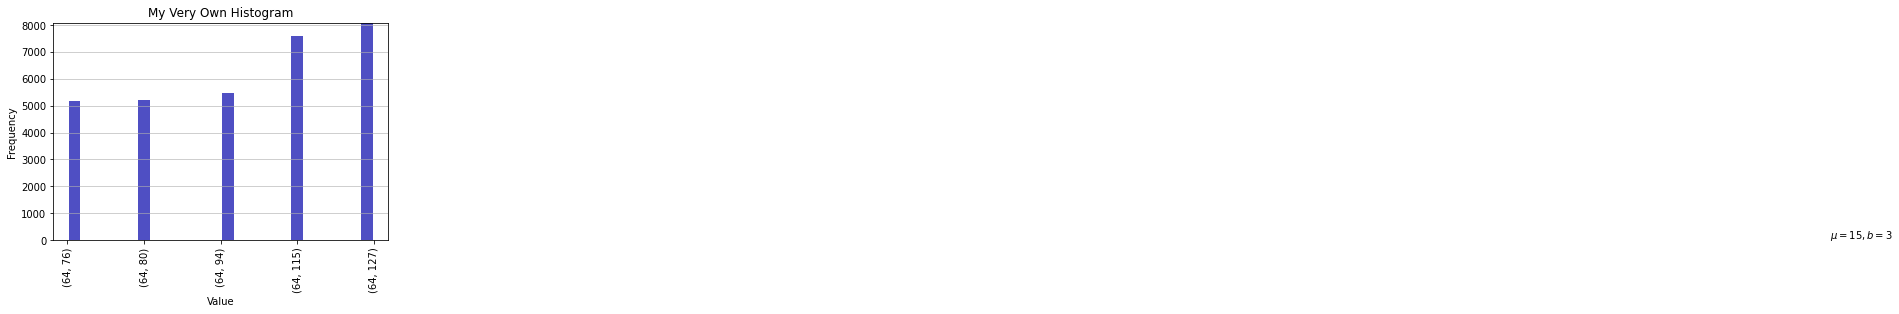

In [372]:
flattened = [(b + 1, e + 1) for m in df.bonds for b, e in m if b == 63]
histo([str(b) for b in sorted(flattened)])

# 6,127
# VFGRCELAAA + WIRGCRL

# 30,115
# GNWVCAAKFE + WRNRCKGTDV

# 64,80
# SRWWCNDGRT + CNIPCSALLS
# WWCNDGR+NLCNIPCSALLSSDITASVNCAK

# 76,94
# SRNLCNIPCS + ASVNCAKKIV

(0.0, 23190.0)

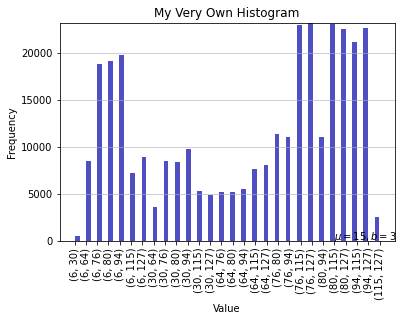

(0.0, 23190.0)

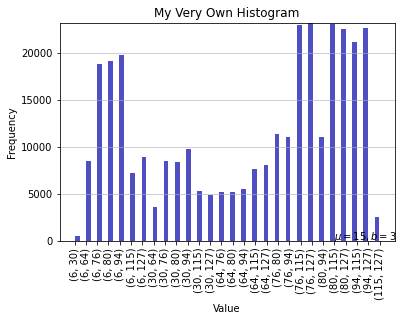

In [374]:

flattened = [(b[0] + 1, b[1] + 1) for m in df.bonds for b in m]
histo([str(b) for b in sorted(flattened)])

In [92]:
tops = []
for f in fragments:
    total = sum(f["measurement"].fragments_intensity)
    top = sorted(
        f["matches"], key=lambda m: sum(f["intensity"] for f in m["fragments"]) / total
    )

    tops.append(
        top[0]
        | {
            "total": total,
            "measurement": f["measurement"],
            "scan": f["measurement"].scan,
        }
    )


KeyError: 'matches'

(-0.05500000000000001, 10.0)

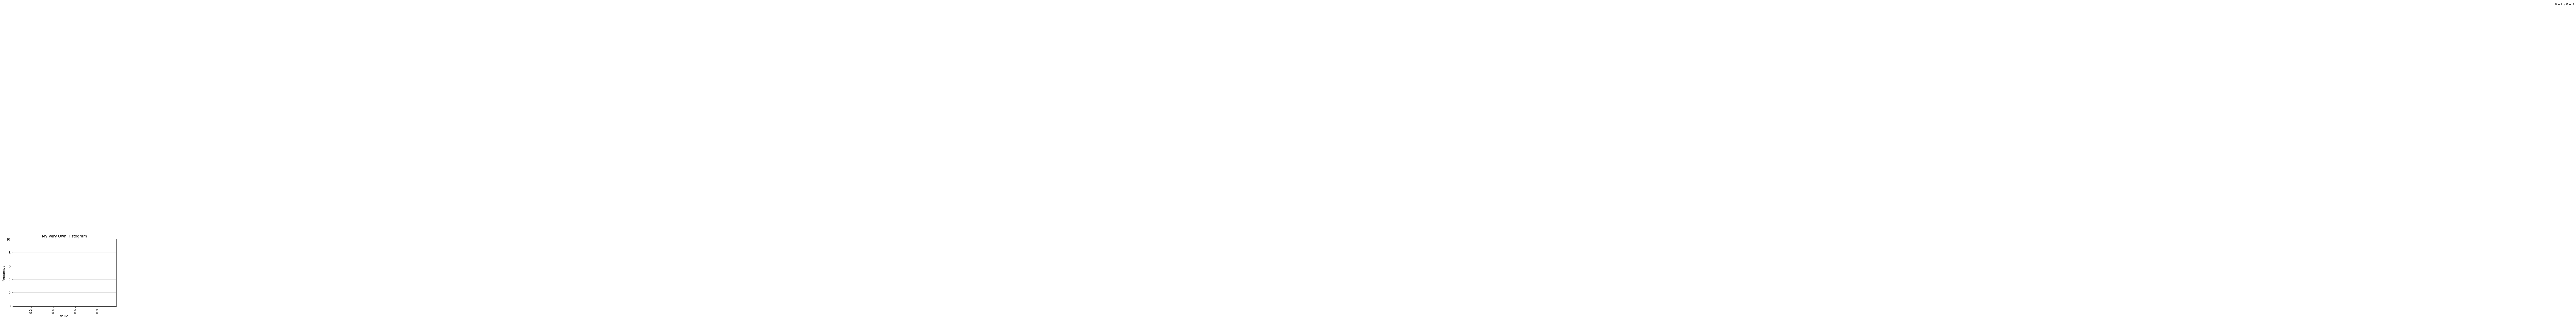

In [371]:
histo(
    [
        100 * sum(f["intensity"] for f in t["fragments"]) / t["total"]
        for t in tops
        if len(t["fragments"]) > 1
    ]
)

In [56]:
peptides = []
for b, e in trypsin(LYS):
    seq = LYS[b:e]
    met_ox = (Mod("met_ox", 15.9949), sum(aa == "M" for aa in seq))
    mods = {"M": met_ox} if "M" in seq else {}
    peptides.append(Peptide(b, e, seq, modifications=mods))

In [49]:
measurements = {m.scan: m for m in read_mgf("../data/mgf/190318_LYS_AT_50x_05.mgf")}

In [55]:
measurements[3208]

In [61]:
precursor_mass_matches(
    peptides,
    measurement=measurements[3208],
    alkylation_mass=57.0214,
    max_inter_bonds=2,
)

[]

In [73]:
peptides

[Peptide(beginning=0, end=1, seq=K, modifications={}),
 Peptide(beginning=1, end=5, seq=VFGR, modifications={}),
 Peptide(beginning=5, end=13, seq=CELAAAMK, modifications={'M': (Mod(description='met_ox', mass=15.9949), 1)}),
 Peptide(beginning=13, end=14, seq=R, modifications={}),
 Peptide(beginning=14, end=21, seq=HGLDNYR, modifications={}),
 Peptide(beginning=21, end=33, seq=GYSLGNWVCAAK, modifications={}),
 Peptide(beginning=33, end=45, seq=FESNFNTQATNR, modifications={}),
 Peptide(beginning=45, end=61, seq=NTDGSTDYGILQINSR, modifications={}),
 Peptide(beginning=61, end=68, seq=WWCNDGR, modifications={}),
 Peptide(beginning=68, end=73, seq=TPGSR, modifications={}),
 Peptide(beginning=73, end=96, seq=NLCNIPCSALLSSDITASVNCAK, modifications={}),
 Peptide(beginning=96, end=97, seq=K, modifications={}),
 Peptide(beginning=97, end=112, seq=IVSDGNGMNAWVAWR, modifications={'M': (Mod(description='met_ox', mass=15.9949), 1)}),
 Peptide(beginning=112, end=114, seq=NR, modifications={}),
 Pepti

In [97]:

sorted_measurements = list(measurements.values())


In [131]:
MEAS = sorted_measurements[3281]
PROTON = mass.calculate_mass(formula="H")

ions = []

for ch in range(1, MEAS.charge + 1):
    print(f"Charge {ch}")

    for f in MEAS.fragments_mz:
        frags = fr.fragments(
            f * ch - PROTON * ch,
            MultiP(
                segments=[
                    Peptide(
                        beginning=45, end=61, seq="NTDGSTDYGILQINSR", modifications={}
                    )
                ],
                disulfide_bonds=[],
                modifications={},
            ),
            allowed_breaks=1,
        )

        if frags:
            for g in frags:
                b = g["ranges"][0][0]
                e = g["ranges"][0][1]
                label = "y" if b > 45 else "b"
                print(f"{label}{61 - b if e == 61 else e - 45}")
                print(g)


Charge 1
y1
{'seq': 'R', 'ranges': [(60, 61)], 'mass': 174.11167570729998, 'error': 1.418855852012121, 'mods': ()}
b2
{'seq': 'NT', 'ranges': [(45, 47)], 'mass': 215.09060590955, 'error': 2.733460243402976, 'mods': ()}
y2
{'seq': 'SR', 'ranges': [(59, 61)], 'mass': 261.14370411157, 'error': 3.8624084138230144, 'mods': ()}
b3
{'seq': 'NTD', 'ranges': [(45, 48)], 'mass': 330.11754893338, 'error': 2.885440513716034, 'mods': ()}
y3
{'seq': 'NSR', 'ranges': [(58, 61)], 'mass': 358.16008245169996, 'error': 2.0934319782791855, 'mods': (Mod(description='–NH3 neutral loss', mass=-17.02654910101),)}
y3
{'seq': 'NSR', 'ranges': [(58, 61)], 'mass': 375.18663155270997, 'error': 4.419974169026143, 'mods': ()}
b4
{'seq': 'NTDG', 'ranges': [(45, 49)], 'mass': 387.13901265395003, 'error': 4.285060212815464, 'mods': ()}
b5
{'seq': 'NTDGS', 'ranges': [(45, 50)], 'mass': 474.17104105822006, 'error': 2.8358760312887266, 'mods': ()}
y4
{'seq': 'INSR', 'ranges': [(57, 61)], 'mass': 488.27069552984, 'error': 

In [133]:
precursor_mass_matches(
    peptides,
    measurement=sorted_measurements[3207],
    alkylation_mass=57.0214,
    max_inter_bonds=2,
)

[{'sequence': 'NTDGSTDYGILQINSR',
  'ranges': [(7, 8)],
  'cysteine_bonds': 0,
  'inter_bonds': 0,
  'intra_bonds': 0,
  'error': 3.2035300166773797,
  'mods': ()}]

In [123]:
Peptide(
    beginning=45, end=61, seq="NTDGSTDYGILQINSR", modifications={}
).zwitterion_mass + mass.calculate_mass("H2O")

1752.82785579296

In [175]:
from collections import Counter

bonds = {}

for t in tops:
    score = sum(f["intensity"] for f in t["fragments"])
    for fr, to in t["multipeptide"]._disulfide_bond.items():
        b = (fr + 1, to + 1)
        if fr < to:
            for f in t["fragments"]:
                for m in f["matches"]:
                    ranges = [range(b, e) for b, e in m["ranges"]]
                    # TODO: Add support for single occurences, but modified in such a way that the bond HAD to be there
                    if any(fr in r for r in ranges) or any(to in r for r in ranges):
                        bonds.setdefault((fr + 1, to + 1), 0)
                        bonds[(fr + 1, to + 1)] += f["intensity"] / t["total"]

# 6,127
# VFGRCELAAA + WIRGCRL

# 30,115
# GNWVCAAKFE + WRNRCKGTDV

# 64,80
# SRWWCNDGRT + CNIPCSALLS
# WWCNDGR+NLCNIPCSALLSSDITASVNCAK

# 76,94
# SRNLCNIPCS + ASVNCAKKIV

In [176]:
for x in sorted(bonds.items(), key=lambda t: -t[1]):
    print(x)

((6, 127), 19.740886165994194)
((94, 115), 9.980073124792092)
((30, 115), 8.506751973533705)
((30, 127), 5.204968659489292)
((6, 76), 4.925631820285177)
((6, 115), 4.373056279949345)
((94, 127), 3.266218754712179)
((80, 115), 3.206963877475632)
((80, 127), 2.643098294071777)
((76, 94), 2.5547956881572653)
((6, 64), 2.0035988700883216)
((64, 127), 1.980858627314984)
((76, 80), 1.9276323518636052)
((6, 94), 1.7564596662233474)
((30, 76), 1.5706443138009445)
((64, 115), 1.367646247427652)
((64, 76), 1.3439958584359852)
((6, 80), 1.3108174876131888)
((115, 127), 1.0201758207932397)
((6, 30), 0.6571873880779388)
((76, 127), 0.5776808055286475)
((30, 94), 0.4997018021904744)
((76, 115), 0.39558572166237477)
((64, 94), 0.29934057435699885)
((30, 64), 0.2824678089628366)
((64, 80), 0.2258536242801691)
((80, 94), 0.11956146071108226)
((30, 80), 0.062078204522398255)


In [177]:
# From old fragment analysis
# ((6, 127), 13.346290121050531)
# ((30, 115), 7.283808779510653)
# ((94, 115), 4.902732231508441)
# ((30, 127), 4.175014297421382)
# ((6, 76), 3.5228414463338105)
# ((6, 115), 3.4146538279373413)
# ((80, 115), 2.652638582827121)
# ((76, 80), 1.8027670677845962)
# ((64, 127), 1.6640611786956967)
# ((94, 127), 1.6384830750559505)
# ((80, 127), 1.6018448515043544)
# ((76, 94), 1.5866929809330261)
# ((6, 64), 1.4861990294897955)
# ((64, 76), 1.171054578671526)
# ((6, 94), 1.1382788403829496)
# ((30, 76), 1.0597983564585203)
# ((6, 80), 1.0528272625199064)
# ((64, 115), 0.9401018143378905)
# ((115, 127), 0.9266341801551622)
# ((76, 127), 0.5575763428777898)
# ((30, 94), 0.48211151877450525)
# ((6, 30), 0.41906206956130065)
# ((76, 115), 0.3512598674841227)
# ((64, 94), 0.23690502620184029)
# ((30, 64), 0.23429644150417078)
# ((64, 80), 0.1591891546235903)
# ((80, 94), 0.031476791393323385)


[6276]

In [357]:
d = pd.DataFrame()

d["scan"] = [m.scan for m in df["measurement"]]
d["precursor_seq"] = [str(m) for m in df["multipeptide"]]
d["precursor_charge"] = [m.charge for m in df["measurement"]]
d["precursor_bonds"] = ["+".join(str(r) for r in b) for b in df["bonds"]]
d["match_seq"] = [m["seq"] for m in df["match"]]
d["charge"] = df["charge"]
d["match_ranges"] = ["+".join(str(r) for r in m["ranges"]) for m in df["match"]]
d["match_mass"] = [m["mass"] for m in df["match"]]
d["connected_bonds"] = [
    "+".join(str(r) for r in m["connected_bonds"]) for m in df["match"]
]
d["disconnected_cys"] = [
    "+".join(str(c) for c in m["disconnected_cys"]) for m in df["match"]
]
d["interesting_disconnected_cys"] = [
    "+".join(str(c) for c in m["interesting_disconnected_cys"]) for m in df["match"]
]

d["match_error_ppm"] = [m["error"] for m in df["match"]]
d["target_mz"] = df["fragment_mz"]
d["intensity"] = df["intensity"]
d["total_intensity"] = df["total_intensity"]

COUNTER = 0
MULTIP_IDS = {}


def multip_id(mp: MultiP):
    key = mp
    global COUNTER
    if mp in MULTIP_IDS:
        return MULTIP_IDS[mp]
    COUNTER += 1
    return MULTIP_IDS.setdefault(
        mp,
    )


In [98]:
d.to_csv("../out/csv/fragment_matches.csv", index_label="id", sep=";")

In [ ]:
precursor_matches = []
with open("../out/precursor_matches_lys_rat_0_segments.pickle", "rb") as f:
    while True:
        precursor_matches.append(pickle.load(f))

In [342]:
from pyteomics.mass import calculate_mass

precursor_matches_df = pd.DataFrame(precursor_matches)
precursor_matches_df["spectrum_id"] = [
    m.id for m in precursor_matches_df["measurement"]
]
precursor_matches_df["scan"] = [m.scan for m in precursor_matches_df["measurement"]]
precursor_matches_df["my_mz"] = [
    (m / msmnt.charge) + calculate_mass(formula="H")
    for m, msmnt in zip(
        precursor_matches_df["mass"], precursor_matches_df["measurement"]
    )
]
precursor_matches_df = precursor_matches_df[
    [
        "spectrum_id",
        "scan",
        "my_mz",
        "error",
        "sequence",
        "mods",
        "cys_bonds",
        "missed_cleavages",
    ]
]

precursor_matches_df = precursor_matches_df.rename(
    columns={
        "error": "my_error_ppm",
        "sequence": "my_sequence",
        "mods": "my_mods",
        "missed_cleavages": "my_missed_cleavages",
    }
)
precursor_matches_df = precursor_matches_df.set_index("spectrum_id")
precursor_matches_df

,scan,my_mz,my_error_ppm,my_sequence,my_mods,cys_bonds,my_missed_cleavages
spectrum_id,,,,,,,
71,903,515.763038,0.639187,RHGLDNYR,(),0,1
101,934,355.844694,0.005825,CELAAAMKR,"(Mod(description='Met Oxidation', mass=15.9949...",0,1
113,947,533.263128,1.135656,CELAAAMKR,"(Mod(description='Met Oxidation', mass=15.9949...",0,1
146,982,437.712482,0.096751,HGLDNYR,(),0,0
198,1040,355.844694,0.338194,CELAAAMKR,"(Mod(description='Met Oxidation', mass=15.9949...",0,1
...,...,...,...,...,...,...,...
14500,16195,1363.294827,6.163145,CELAAAMKRHGLDNYRGYSLGNWVCAAK+WWCNDGR,"(Mod(description='Alkylated Cys', mass=57.0214),)",1,3
14506,16205,409.975343,1.414521,KVFGRCELAAAMKR,"(Mod(description='Alkylated Cys', mass=57.0214),)",0,3
14507,16207,714.829303,1.086133,FESNFNTQATNR,(),0,0


In [349]:
from pymzid.read_mzid import Mzid
from fragments import compute_error

mgf_id = Mzid("../data/mgf/190318_LYS_RAT_50x_05.mzid")
mgf_id.read_psm()
msgf_matches_df = mgf_id.psm_df

msgf_matches_df.head(30)

Reading peptide spectrum matches: 100%|█████████▉| 1217/1218 [00:00<00:00, 42781.09it/s]


,sir_id,spectrum_id,pe_id,sii_id,z,mz,calc_mz,pep_id,pass_threshold,rank,MS-GF:RawScore,MS-GF:DeNovoScore,MS-GF:SpecEValue,MS-GF:EValue
0,SIR_5123,index=5122,PepEv_22_GYSLGNWVCAAKFESNFNTQATNR_22,SII_5123_1,3,912.427001953125,912.435791015625,Pep_GYSLGNWVCAAKFESNFNTQATNR,true,1,175,176,1.9008859E-30,2.4521429E-28
1,SIR_4648,index=4647,PepEv_22_GYSLGNWVCAAKFESNFNTQATNR_22,SII_4648_1,3,912.42822265625,912.435791015625,Pep_GYSLGNWVCAAKFESNFNTQATNR,true,1,167,169,4.8748996E-30,6.2886206E-28
2,SIR_4370,index=4369,PepEv_34_FESNFNTQATNRNTDGSTDYGILQINSR_34,SII_4370_1,3,1055.162109375,1055.1607666015625,Pep_FESNFNTQATNRNTDGSTDYGILQINSR,true,1,159,174,2.1087976E-27,2.7203489E-25
3,SIR_4503,index=4502,PepEv_34_FESNFNTQATNRNTDGSTDYGILQINSR_34,SII_4503_1,3,1055.162109375,1055.1607666015625,Pep_FESNFNTQATNRNTDGSTDYGILQINSR,true,1,155,165,5.184633E-27,6.6881767E-25
4,SIR_4433,index=4432,PepEv_34_FESNFNTQATNRNTDGSTDYGILQINSR_34,SII_4433_1,3,1055.498046875,1055.1607666015625,Pep_FESNFNTQATNRNTDGSTDYGILQINSR,true,1,153,171,2.9292433E-26,3.778724E-24
5,SIR_4781,index=4780,PepEv_34_FESNFNTQATNRNTDGSTDYGILQINSR_34,SII_4781_1,3,1055.1624755859375,1055.1607666015625,Pep_FESNFNTQATNRNTDGSTDYGILQINSR,true,1,115,141,1.0629297E-25,1.3711793E-23
6,SIR_12433,index=12432,PepEv_34_FESNFNTQATNRNTDGSTDYGILQINSR_34,SII_12433_1,3,1055.1634521484375,1055.1607666015625,Pep_FESNFNTQATNRNTDGSTDYGILQINSR,true,1,130,152,1.7940855E-25,2.3143704E-23
7,SIR_5083,index=5082,PepEv_34_FESNFNTQATNRNTDGSTDYGILQINSR_34,SII_5083_1,3,1055.1627197265625,1055.1607666015625,Pep_FESNFNTQATNRNTDGSTDYGILQINSR,true,1,128,147,7.9793734E-25,1.02933916E-22
8,SIR_10326,index=10325,PepEv_34_FESNFNTQATNRNTDGSTDYGILQINSR_34,SII_10326_1,3,1055.16357421875,1055.1607666015625,Pep_FESNFNTQATNRNTDGSTDYGILQINSR,true,1,118,134,9.035872E-25,1.1656276E-22
9,SIR_5839,index=5838,PepEv_34_FESNFNTQATNRNTDGSTDYGILQINSR_34,SII_5839_1,3,1055.163330078125,1055.1607666015625,Pep_FESNFNTQATNRNTDGSTDYGILQINSR,true,1,93,111,1.8105348E-24,2.33559E-22


In [ ]:
msgf_matches_df["spectrum_id"] = [
    int(s.removeprefix("index=")) for s in msgf_matches_df["spectrum_id"]
]
msgf_matches_df["pep_id"] = [s.removeprefix("Pep_") for s in msgf_matches_df["pep_id"]]
msgf_matches_df["their_error_ppm"] = [
    compute_error(float(reference), float(measured))
    for reference, measured in zip(msgf_matches_df["calc_mz"], msgf_matches_df["mz"])
]

msgf_matches_df = msgf_matches_df[
    ["spectrum_id", "calc_mz", "pep_id", "their_error_ppm"]
]
msgf_matches_df = msgf_matches_df.rename(
    columns={"pep_id": "their_sequence", "calc_mz": "their_mz"}
)
msgf_matches_df = msgf_matches_df.set_index("spectrum_id")
msgf_matches_df

In [345]:
precursor_matches_df.join(msgf_matches_df, how="outer").to_csv(
    "../out/my_vs_their_matches_rat.csv"
)

In [317]:
measurements[3104].peptide_mass_estimate - calculate_mass("NTDGSTDYGILQINSR")

0.018651695947937696

In [386]:
segment_counter = Counter()
for m in precursor_matches:
    for b, e in m["ranges"]:
        for s in range(b, e):
            segment_counter[s] += 1
segment_counter

Counter({3: 739,
         4: 602,
         2: 969,
         14: 1075,
         8: 475,
         9: 436,
         0: 360,
         1: 505,
         6: 583,
         16: 755,
         13: 580,
         15: 773,
         11: 508,
         12: 448,
         17: 330,
         5: 731,
         10: 901,
         7: 399})

In [387]:
segments = list(segment_counter.keys())
total = sum(segment_counter.values())
segment_probabilities = []
for s in range(min(segments), max(segments) + 1):
    segment_probabilities.append(segment_counter[s] / total)
segment_probabilities

[0.032232070910556,
 0.045214432805085504,
 0.0867579908675799,
 0.0661652788969469,
 0.053899185244874206,
 0.0654490106544901,
 0.05219804816903931,
 0.035723878592532905,
 0.0425284268958725,
 0.039036619213895604,
 0.0806697108066971,
 0.0454830333960068,
 0.040111021577580806,
 0.05192944757811801,
 0.09624854508013252,
 0.06920941892738831,
 0.06759781538186051,
 0.029546065001343002]

In [393]:
precursor_probabilities = []
for f in fragments:
    probability = 1
    for b, e in f["precursor"]["ranges"]:
        for s in range(b, e):
            probability *= segment_probabilities[s]
    precursor_probabilities.append(probability)
precursor_probabilities[:10]

[0.0058646506495678066,
 0.0058646506495678066,
 0.0058646506495678066,
 0.0058646506495678066,
 0.0058646506495678066,
 0.0058646506495678066,
 0.0058646506495678066,
 0.0058646506495678066,
 0.0058646506495678066,
 0.0058646506495678066]

In [433]:
import networkx as nx
import matplotlib.pyplot as plt

protein = LYS
cysteines = [i for i in range(len(protein)) if protein[i] == "C"]

import itertools
from collections import Counter

possible_bonds = list(itertools.combinations(cysteines, 2))
positive_evidence = {b: 0 for b in possible_bonds}
negative_evidence = {b: 0 for b in possible_bonds}

DIRECT_POS_WEIGHT = 1
NEG_WEIGHT = 1
INDIRECT_POS_WEIGHT = 1

for m, prob in zip(fragments, precursor_probabilities):
    for b in m["match"]["connected_bonds"]:
        positive_evidence[b] += prob * DIRECT_POS_WEIGHT
        for x, y in negative_evidence:
            if (x, y) != b and (x in b or y in b):
                # We're looking at A<–>B, every other bond with A or B is decreased
                negative_evidence[(x, y)] += prob * NEG_WEIGHT
    for c in m["match"]["interesting_disconnected_cys"]:
        for b in positive_evidence:
            if c in b:
                positive_evidence[b] += prob * INDIRECT_POS_WEIGHT

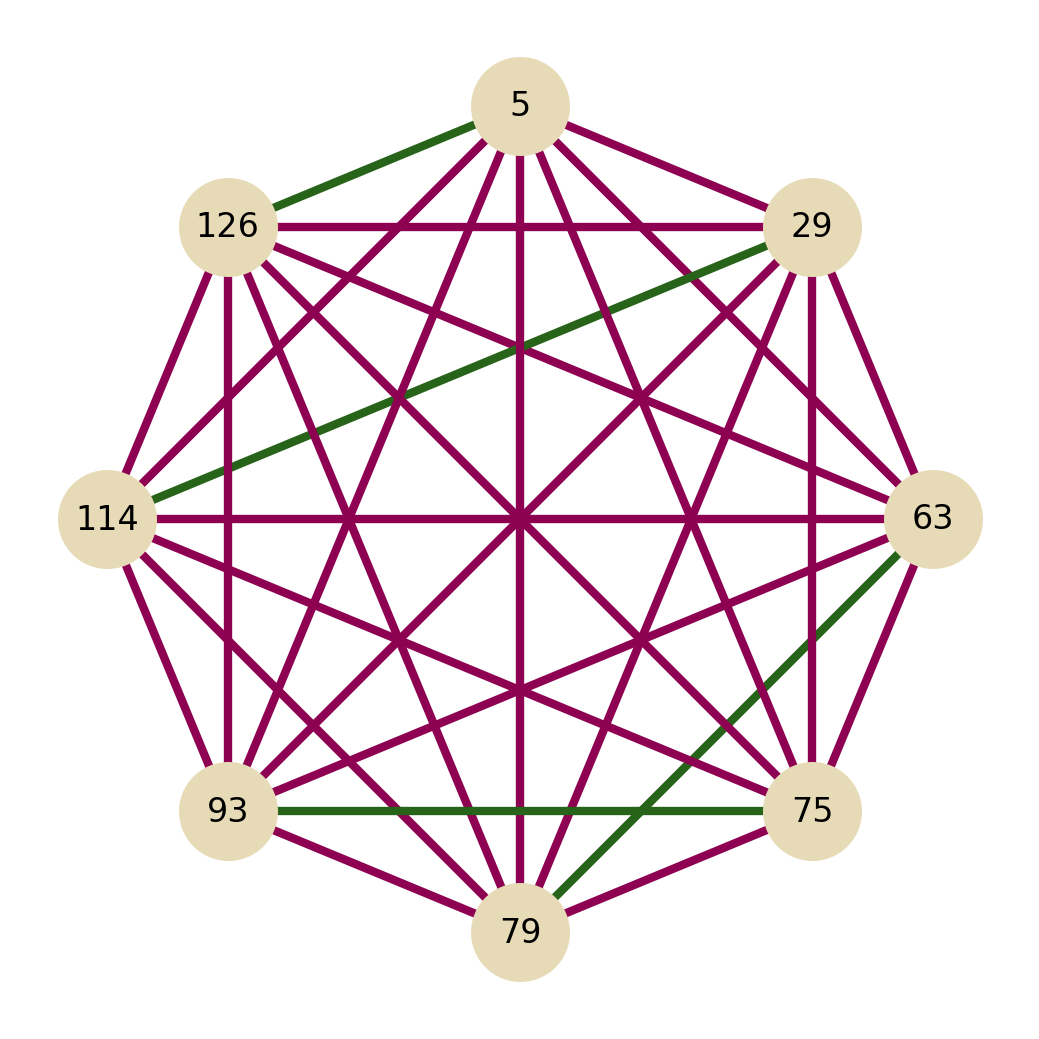

In [436]:
CMAP = plt.get_cmap("PiYG")

# IDEAL GRAPH
g = nx.complete_graph(reversed(cysteines[3:] + cysteines[:3]))
plt.figure(figsize=(5, 5), dpi=200)

edges = [tuple(sorted(e)) for e in g.edges()]
scores = [e in [(5, 126), (29, 114), (63, 79), (75, 93)] for e in edges]
scores_normalized = [
    abs(s - min(scores)) / abs(max(scores) - min(scores)) for s in scores
]
colors = [CMAP(s) for s in scores_normalized]

nx.draw_circular(
    g,
    with_labels=True,
    node_size=1200,
    node_color="#E7DBB7",
    edge_color=colors,
    width=3,
)

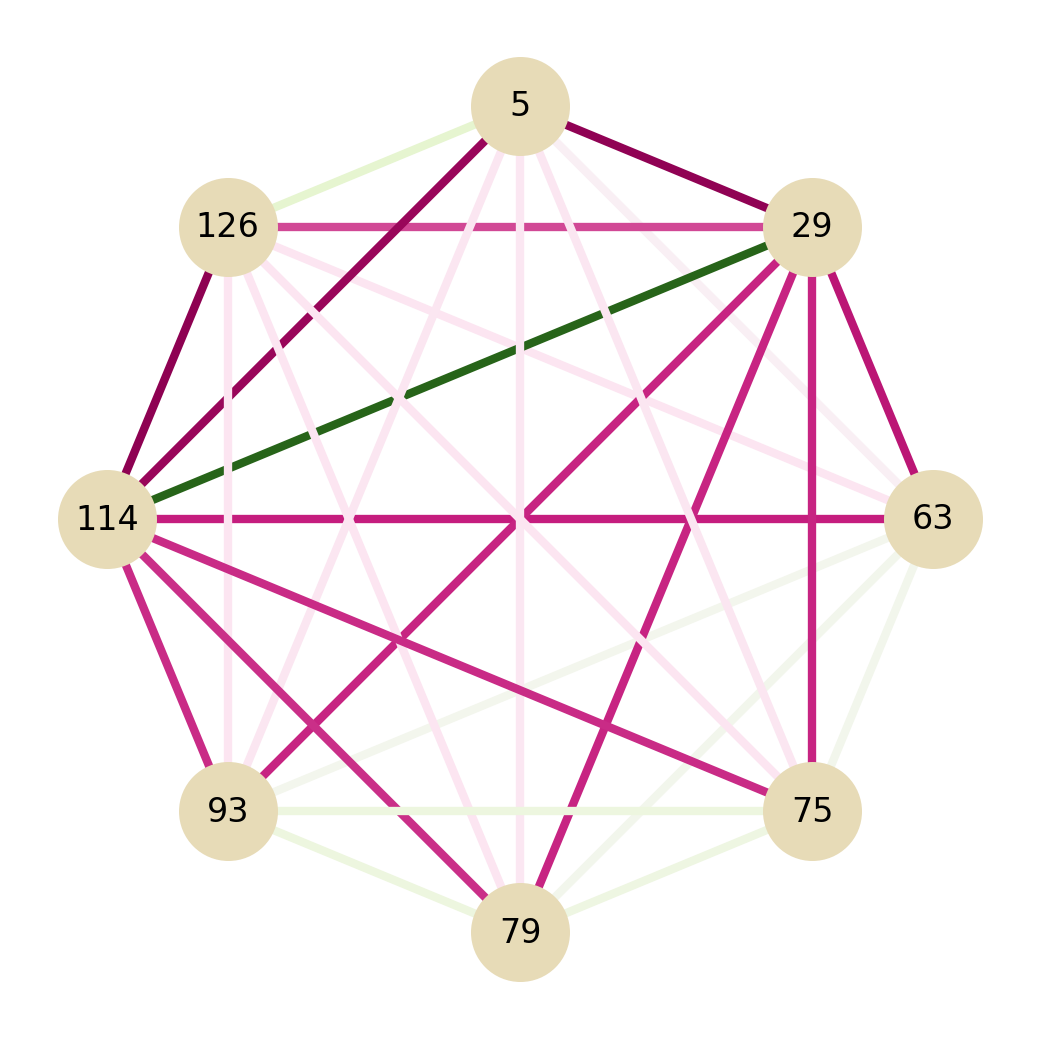

In [437]:
g = nx.complete_graph(reversed(cysteines[3:] + cysteines[:3]))
plt.figure(figsize=(5, 5), dpi=200)

edges = [tuple(sorted(e)) for e in g.edges()]
scores = [positive_evidence[e] - negative_evidence[e] for e in edges]
scores_normalized = [
    abs(s - min(scores)) / abs(max(scores) - min(scores)) for s in scores
]
colors = [CMAP(s) for s in scores_normalized]

nx.draw_circular(
    g,
    with_labels=True,
    node_size=1200,
    node_color="#E7DBB7",
    edge_color=colors,
    width=3,
)

In [438]:
list(zip(edges, scores_normalized))

[((29, 63), 0.08512655326179365),
 ((5, 63), 0.4654085515970303),
 ((63, 126), 0.42006377741429446),
 ((63, 114), 0.10491643552736599),
 ((63, 93), 0.5264070292577601),
 ((63, 79), 0.5285783985443103),
 ((63, 75), 0.5273660720341423),
 ((5, 29), 0.0040065705360421925),
 ((29, 126), 0.15056667861169182),
 ((29, 114), 1.0),
 ((29, 93), 0.11022128013900982),
 ((29, 79), 0.11241519447745865),
 ((29, 75), 0.11094502667494306),
 ((5, 126), 0.5998702338220392),
 ((5, 114), 0.023165589061286757),
 ((5, 93), 0.4274650008015889),
 ((5, 79), 0.43008537179412837),
 ((5, 75), 0.4286954757436176),
 ((114, 126), 0.0),
 ((93, 126), 0.42117231169358),
 ((79, 126), 0.42352925644669703),
 ((75, 126), 0.4228166294737141),
 ((93, 114), 0.11864988415430622),
 ((79, 114), 0.12181907534416839),
 ((75, 114), 0.12078574452289548),
 ((79, 93), 0.5594636186360695),
 ((75, 93), 0.5619280342201061),
 ((75, 79), 0.5542943564385135)]